In [326]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, RFE
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, bayes_mvs
from scipy.fft import fft
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr

# DATASET OVERVIEW

In [327]:
# Loading the dataset and printing a few rows
data = pd.read_csv('accidents.csv')
data.head()

,Severity,StartTime,EndTime,StartLat,StartLng,Distance,Street,City,State,Zipcode,...,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal
0,2,2019-07-22 14:43:06,2019-07-22 16:22:19,34.789009,-82.483383,0.000,Highway 153,Greenville,SC,29611,...,False,False,False,False,False,False,False,False,False,False
1,2,2019-03-20 16:12:14,2019-03-20 16:41:05,40.998264,-76.650396,0.472,Continental Blvd,Danville,PA,17821,...,False,False,False,False,False,False,False,False,False,False
2,3,2018-12-12 14:19:18,2018-12-12 14:48:56,33.461292,-112.082001,0.000,I-10 W,Phoenix,AZ,85003,...,False,False,False,False,False,False,False,False,False,False
3,2,2018-03-09 08:02:11,2018-03-09 08:49:15,42.288445,-87.924911,0.000,Oak Spring Rd,Libertyville,IL,60048,...,False,False,False,False,False,False,False,False,False,False
4,2,2020-03-27 05:36:56,2020-03-27 06:36:48,36.229259,-86.594650,0.000,Saundersville Rd,Old Hickory,TN,37138,...,False,False,False,False,False,False,False,False,False,False


In [328]:
#Giving data overview
print(f"Number of Rows: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")
print("\n----- Data Types -----")
print(data.dtypes)

Number of Rows: 100000
Number of Columns: 29

----- Data Types -----
Severity              int64
StartTime            object
EndTime              object
StartLat            float64
StartLng            float64
Distance            float64
Street               object
City                 object
State                object
Zipcode               int64
Temperature         float64
Humidity            float64
Pressure            float64
Visibility          float64
WindSpeed           float64
Precipitation       float64
WeatherCondition     object
Amenity                bool
Bump                   bool
Crossing               bool
GiveWay                bool
Junction               bool
NoExit                 bool
Railway                bool
Roundabout             bool
Station                bool
Stop                   bool
TrafficCalming         bool
TrafficSignal          bool
dtype: object


# DATA PREPROCESSING

CREATING NEW ATTRIBUTES

In [329]:
# Converting 'StartTime' and 'EndTime' to datetime format, handling the specific format
data['StartTime'] = pd.to_datetime(data['StartTime'], errors='coerce')
data['EndTime'] = pd.to_datetime(data['EndTime'], errors='coerce')

# Creation the 'Date' column at the start from 'StartTime'
data['Date'] = data['StartTime'].dt.date

# Creation of new features: accident duration and hour of the day
data['Duration'] = (data['EndTime'] - data['StartTime']).dt.total_seconds() / 60  # Duration in minutes
data['AccidentHour'] = data['StartTime'].dt.hour

# VISUALIZATIONS

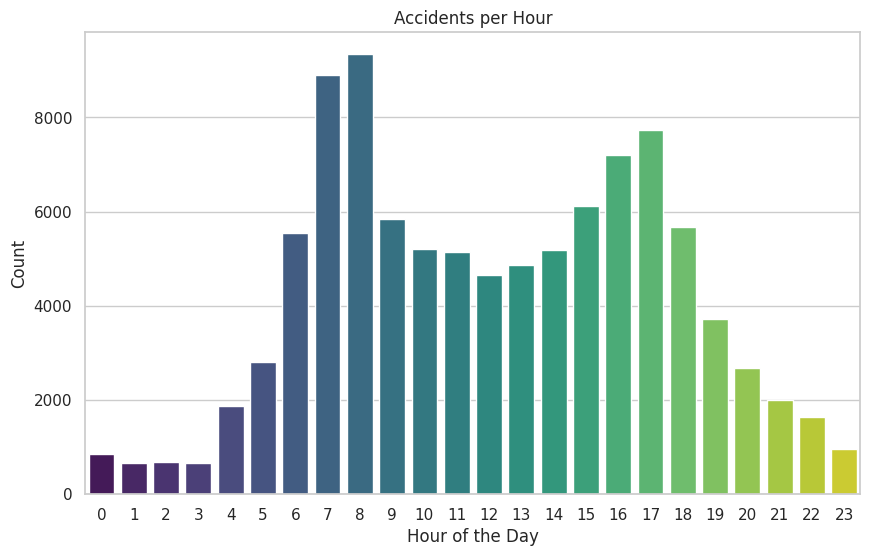

In [330]:
# Visualizations
sns.set(style="whitegrid")

# Accidents per Hour Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='AccidentHour', data=data, palette="viridis")
plt.title('Accidents per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.show()

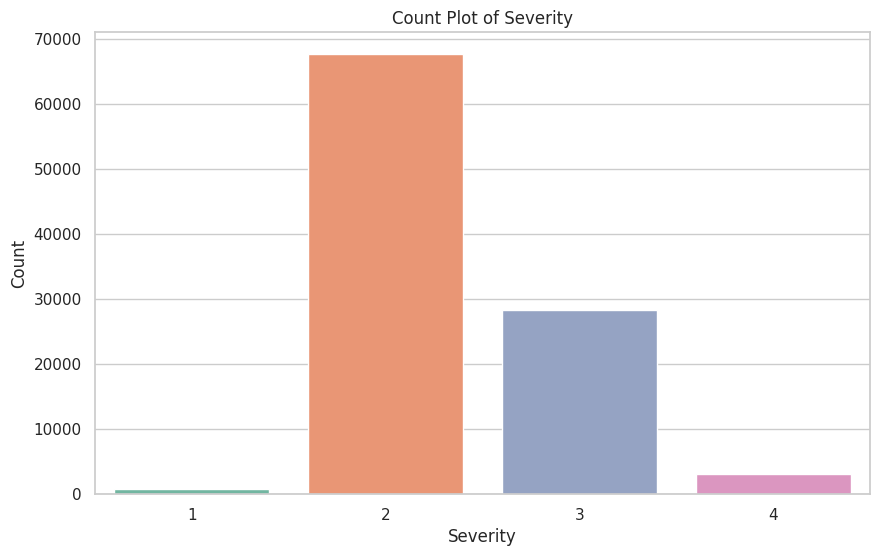

In [331]:
# Count Plot of Severity
plt.figure(figsize=(10, 6))
sns.countplot(x='Severity', data=data, palette="Set2")
plt.title('Count Plot of Severity')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

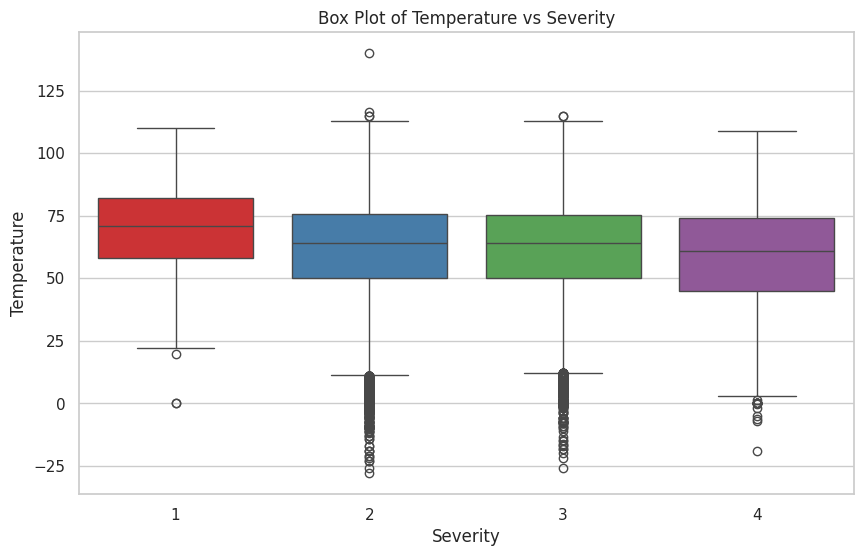

In [332]:
# Box Plot of Temperature vs Severity (if Temperature exists)
if 'Temperature' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Severity', y='Temperature', data=data, palette="Set1")
    plt.title('Box Plot of Temperature vs Severity')
    plt.xlabel('Severity')
    plt.ylabel('Temperature')
    plt.show()

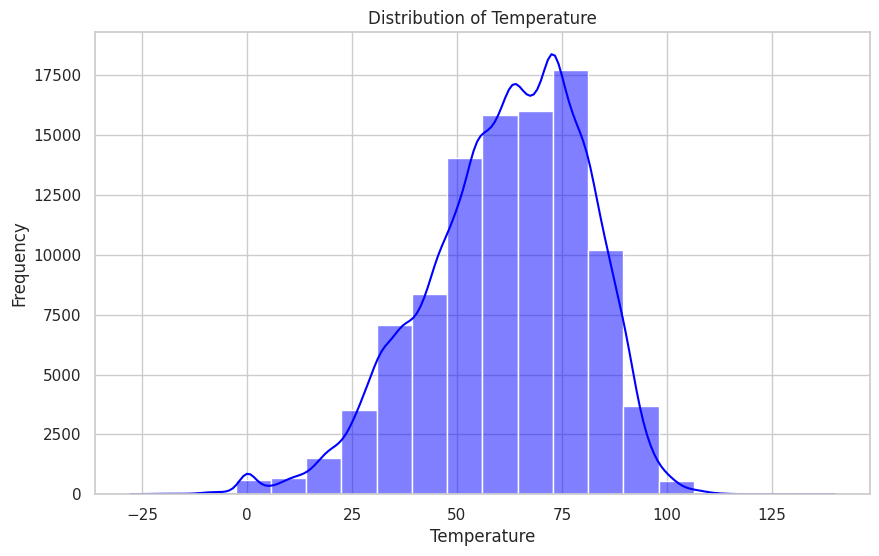

In [333]:
# Distribution Plot of Temperature (if available)
if 'Temperature' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Temperature'], kde=True, color="blue", bins=20)
    plt.title('Distribution of Temperature')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()

# DATA PREPROCESSING (CONT.)

In [334]:
# Print number of instances before preprocessing
print(f"Number of instances before preprocessing: {data.shape[0]}")

Number of instances before preprocessing: 100000


DROPPING IRRELEVANT FEATURES, CONVERTING FEATURES TO PROER FORMAT AND DROPPING ROWS WITH NULL VALUES

In [335]:
# Drop columns not necessary for prediction (including 'StartTime' and 'EndTime' after creating new features)
columns_to_drop = ['StartTime', 'EndTime', 'Street', 'City', 'State', 'Zipcode', 'Station']
data = data.drop(columns=columns_to_drop)

# Convert Severity to integer if it is not already (ensure it's categorical)
data['Severity'] = pd.to_numeric(data['Severity'], errors='coerce')
data = data.dropna(subset=['Severity'])
data['Severity'] = data['Severity'].astype('int')

# Ensure 'Duration' is numeric and handle invalid values
data['Duration'] = pd.to_numeric(data['Duration'], errors='coerce')

# Separate the numeric and categorical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Severity')
categorical_columns = data.select_dtypes(include=[object]).columns

HANDLING MISSING VALUES BY DROPPING ROWS WHICH ARE CRITICAL ATTRIBUTES. ALL THE OTHER ATTRIBUTES BY REPLACING THEM WITH MEAN

In [336]:
# Drop rows with NaN values in 'Duration' or 'Severity' columns
data = data.dropna(subset=['Duration', 'Severity'])

# Define imputers
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

FEATURE ENGINEERING

In [337]:
# Apply transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_imputer, numeric_columns),
        ('cat', categorical_imputer, categorical_columns)
    ])

data_imputed = pd.DataFrame(preprocessor.fit_transform(data), columns=numeric_columns + categorical_columns.tolist())

# Encode categorical features
label_encoder = LabelEncoder()
for col in categorical_columns:
    if col in data_imputed.columns:
        data_imputed[col] = label_encoder.fit_transform(data_imputed[col])

# Re-add the Severity column to data_imputed for plotting
data_imputed['Severity'] = data['Severity'].values

OUTLIER DETECTION USING IQR

In [338]:
# Detecting outliers using IQR method
def detect_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        df = df.drop(outliers)
    return df

numeric_columns = ['Duration', 'StartLat', 'StartLng', 'Distance']
data_cleaned = detect_outliers(data_imputed, numeric_columns)

In [339]:
# Print the number of instances after preprocessing
print(f"Number of instances after preprocessing: {data_cleaned.shape[0]}")

Number of instances after preprocessing: 66438


In [340]:
# Print data head after preprocessing
print(data_cleaned.head())

    StartLat    StartLng Distance Temperature Humidity Pressure Visibility  \
0  34.789009  -82.483383      0.0        93.0     45.0    28.86       10.0   
2  33.461292 -112.082001      0.0        64.9     40.0    29.99       10.0   
3  42.288445  -87.924911      0.0        27.0     63.0    30.04       10.0   
4  36.229259   -86.59465      0.0        68.0     65.0     29.2       10.0   
5   39.61181   -86.48578      0.0        54.0     97.0    28.81        4.0   

  WindSpeed Precipitation   Duration AccidentHour  WeatherCondition  Date  \
0      16.0           0.0  99.216667         14.0                10  1237   
2       8.1           0.0  29.633333         14.0                51  1015   
3       5.8           0.0  47.066667          8.0                46   737   
4       7.0           0.0  59.866667          5.0                46  1485   
5       9.0           0.0       45.0         15.0                34  1512   

   Severity  
0         2  
2         3  
3         2  
4         2 

# FEATURE SELECTION

<Figure size 1200x1200 with 0 Axes>

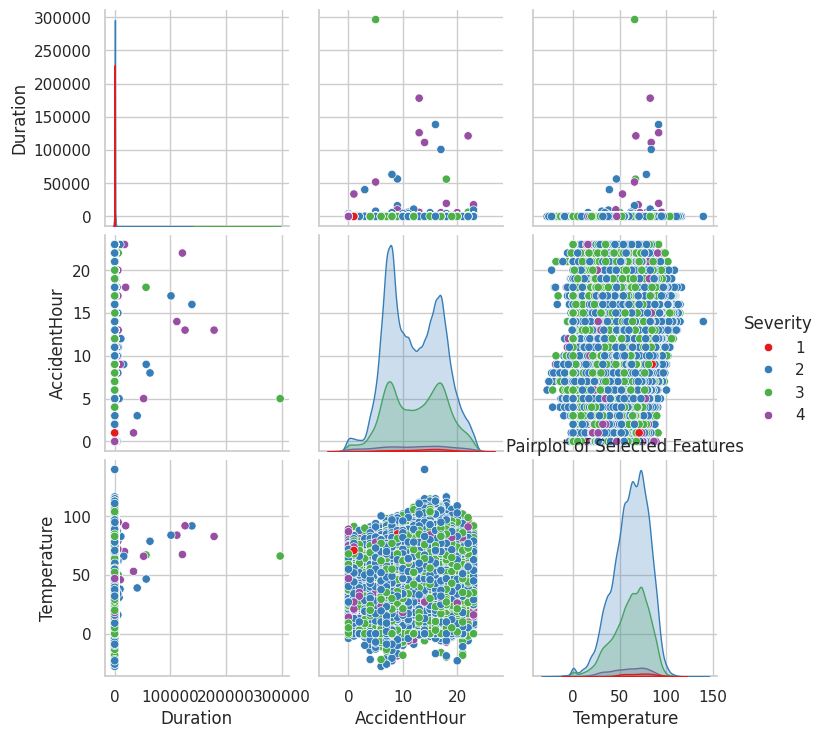

In [341]:
# Pairplot of Selected Features
selected_features = ['Duration', 'AccidentHour', 'Temperature', 'Severity']
plt.figure(figsize=(12, 12))
valid_features = [col for col in selected_features if col in data_imputed.columns]
sns.pairplot(data_imputed[valid_features], hue='Severity', palette="Set1")
plt.title('Pairplot of Selected Features')
plt.show()

In [342]:
# Feature selection using mutual information
X = data_cleaned.drop(columns=['Severity'])
y = data_cleaned['Severity']
mi = mutual_info_classif(X, y)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n\n", mi_scores)

# Select top features based on mutual information scores
top_features = mi_scores.index[:10].tolist()
X = X[top_features]

# Reduce redundancy using Pearson correlation
def reduce_redundant_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop)

X = reduce_redundant_features(X)

Mutual Information Scores:

 StartLng            0.165225
StartLat            0.149930
Duration            0.074720
Date                0.050063
WeatherCondition    0.013431
WindSpeed           0.012950
Temperature         0.010648
Pressure            0.010134
Visibility          0.003605
Humidity            0.003410
AccidentHour        0.001994
Precipitation       0.001431
Distance            0.000000
dtype: float64



BASED ON THE ABOVE MUTUAL INFORMATION SCORES, WE SELECT THE TOP 4 ATTRIBUTES AS:


---


STARTLNG: Longitude of the accident location

STARTLAT: Latitude of the accident location

DURATION: Duration of the accident

DATE:- Date of the accident


---


THESE ATTRIBUTES HAVE THE STRONGEST RELATIONSHIP WITH ACCIDENT "SEVERITY" ATTRIBUTE.

# HYPOTHESIS TESTING

ANOVA TEST

In [343]:
# ANOVA test: Severity vs Duration
anova_result = f_oneway(*[data[data['Severity'] == s]['Duration'] for s in data['Severity'].unique()])
print(f"ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

ANOVA F-statistic: 56.076544484066375, p-value: 3.289895729779607e-36


The ANOVA test examines whether there is a statistically significant difference in accident durations across different levels of severity (e.g., Severity 1, 2, 3, etc.). The test computes an F-statistic and a corresponding p-value.


**F-statistic: 56.0765** indicates the ratio of variability between the severity groups compared to the variability within the groups.

**p-value: 3.2898e-36,** which is extremely small (far less than the usual significance level of 0.05), confirms that there are significant differences in accident durations between severity levels.


This result suggests that accident severity is strongly influenced by the duration of the accident, making it a valuable predictor for understanding accident severity patterns. However, it does not specify which severity levels differ significantly; further post-hoc analysis could be conducted for that purpose.

T-TEST

In [344]:
# T-test: Comparing Duration for Severity 2 and 3
group_2 = data[data['Severity'] == 2]['Duration']
group_3 = data[data['Severity'] == 3]['Duration']
t_stat, p_val = ttest_ind(group_2, group_3)
print(f"T-test statistic: {t_stat}, p-value: {p_val}")

T-test statistic: 2.142883815952499, p-value: 0.03212493512036289


The T-test compares the accident durations for two specific severity levels, 2 and 3, to determine whether their average durations differ significantly.


**T-statistic: 2.1429** measures the difference between the group means relative to the variability in the groups.

**p-value: 0.0321** indicates that there is a statistically significant difference between the durations for severity levels 2 and 3 (p < 0.05).


This means that accidents classified as severity 2 and severity 3 are likely to have different average durations, implying that duration could help differentiate between these two levels of severity.

CHI-SQUARE TEST

In [345]:
# Chi-square test: Severity and Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['StartLat', 'StartLng']])
contingency_table = pd.crosstab(data['Severity'], data['Cluster'])
chi2, chi_p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {chi_p}")

Chi-square statistic: 875.4186143502733, p-value: 7.737295310995895e-186


The Chi-Square test examines the relationship between accident severity and spatial clustering of accident locations. Clusters were generated using K-Means clustering based on latitude and longitude coordinates, and a contingency table was created to test for dependence between severity and cluster membership.


**Chi-Square Statistic: 875.4186** quantifies how much the observed frequencies deviate from the expected frequencies under the assumption of independence.


**p-value: 7.7373e-186,** which is extremely small, indicates a very strong dependency between severity levels and geographical clusters.


This result suggests that accident severity is influenced by the geographical location of the accident. Some clusters (locations) may be prone to more severe accidents than others, possibly due to local traffic conditions, road infrastructure, or weather conditions. This information could be useful for targeted interventions in high-risk areas.

CLUSTERING SEVERITY BASED ON LOCATION WITH LATITUTE AND LONGITUDE

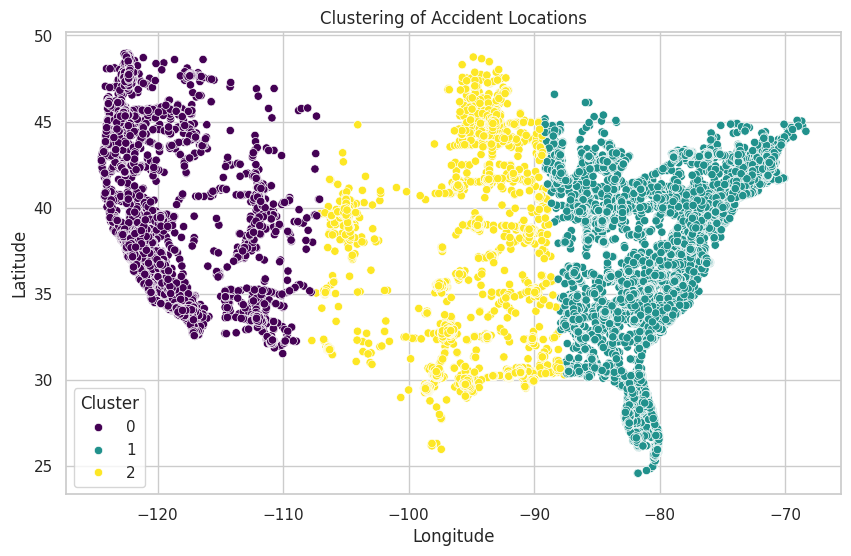

In [346]:
# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['StartLat', 'StartLng']])

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='StartLng',
    y='StartLat',
    hue='Cluster',
    palette='viridis',
    data=data
)
plt.title('Clustering of Accident Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.show()

# TRAINING AND TESTING

STANDARDIZING AND SPLITTING THE DATA INTO TRAINING AND TESTING

In [347]:
# Split the data: 80% for training, 20% for testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Standardize the data
sc_x = StandardScaler()
X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_x.transform(X_test)

PRINCIPAL COMPONENT ANALYSIS

In [348]:
# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

SPEARMAN CORRELATION

In [349]:
y_test_array = np.array(y_test)
y_test_pred_lr_array = np.array(y_test_pred_lr)

# Calculate Spearman Correlation
if len(np.unique(y_test_pred_lr_array)) > 1:
    correlation, _ = spearmanr(y_test_array, y_test_pred_lr_array)
    print(f'Spearman Correlation: {correlation:.3f}')
else:
    print('Spearman Correlation: Undefined (constant predictions)')

Spearman Correlation: 0.158


USING MULTIPLE LINEAR REGRESSION

In [350]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_std, y_train)
y_train_pred_lr = lr.predict(X_train_std)
y_test_pred_lr = lr.predict(X_test_std)

print('Linear Regression:')
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_lr),
    mean_squared_error(y_test, y_test_pred_lr)))
print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred_lr),
    r2_score(y_test, y_test_pred_lr)))
print('Spearman Correlation: %.3f' % spearmanr(y_test, y_test_pred_lr)[0])

Linear Regression:
MSE train: 0.221, test: 0.220
R^2 train: 0.024, test: 0.022
Spearman Correlation: 0.152


In [351]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_std, y_train)
y_train_pred_ridge = ridge.predict(X_train_std)
y_test_pred_ridge = ridge.predict(X_test_std)

print('Ridge Regression:')
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_ridge),
    mean_squared_error(y_test, y_test_pred_ridge)))
print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred_ridge),
    r2_score(y_test, y_test_pred_ridge)))
print('Spearman Correlation: %.3f' % spearmanr(y_test, y_test_pred_ridge)[0])

Ridge Regression:
MSE train: 0.221, test: 0.220
R^2 train: 0.024, test: 0.022
Spearman Correlation: 0.152


In [352]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_std, y_train)
y_train_pred_lasso = lasso.predict(X_train_std)
y_test_pred_lasso = lasso.predict(X_test_std)

print('Lasso Regression:')
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_lasso),
    mean_squared_error(y_test, y_test_pred_lasso)))
print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred_lasso),
    r2_score(y_test, y_test_pred_lasso)))
print('Spearman Correlation: %.3f' % spearmanr(y_test, y_test_pred_lasso)[0])

Lasso Regression:
MSE train: 0.226, test: 0.225
R^2 train: 0.000, test: -0.000
Spearman Correlation: nan


In [353]:
# Elastic Net Regression
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_std, y_train)
y_train_pred_en = elastic_net.predict(X_train_std)
y_test_pred_en = elastic_net.predict(X_test_std)

print('Elastic Net Regression:')
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_en),
    mean_squared_error(y_test, y_test_pred_en)))
print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred_en),
    r2_score(y_test, y_test_pred_en)))
print('Spearman Correlation: %.3f' % spearmanr(y_test, y_test_pred_en)[0])

Elastic Net Regression:
MSE train: 0.225, test: 0.223
R^2 train: 0.007, test: 0.006
Spearman Correlation: 0.131


RESULTS OF THE ALL THE REGRESSION MODELS

In [354]:
# Summary Table for Model Performance
results = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net'],
    'MSE': [
        mean_squared_error(y_test, y_test_pred_lr),
        mean_squared_error(y_test, y_test_pred_lasso),
        mean_squared_error(y_test, y_test_pred_ridge),
        mean_squared_error(y_test, y_test_pred_en)
    ],
    'R2': [
        r2_score(y_test, y_test_pred_lr),
        r2_score(y_test, y_test_pred_lasso),
        r2_score(y_test, y_test_pred_ridge),
        r2_score(y_test, y_test_pred_en)
    ],
    'Spearman Correlation': [
        spearmanr(y_test, y_test_pred_lr)[0],
        spearmanr(y_test, y_test_pred_lasso)[0],
        spearmanr(y_test, y_test_pred_ridge)[0],
        spearmanr(y_test, y_test_pred_en)[0]
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model       MSE        R2  Spearman Correlation
0  Linear Regression  0.219591  0.021899              0.151853
1   Lasso Regression  0.224514 -0.000028                   NaN
2   Ridge Regression  0.219591  0.021899              0.151853
3        Elastic Net  0.223126  0.006154              0.131327


**Linear Regression and Ridge Regression** perform identically, with an MSE of 0.2196 and an R² value of 0.0219, indicating that only about 2.2% of the variance in the target variable is explained by the features. The Spearman Correlation of 0.1519 suggests a weak positive monotonic relationship between the predictions and actual values.

**Lasso Regression** shows a slightly higher MSE of 0.2245 and a near-zero R² of -0.00003, meaning it fails to explain any variance in the target variable. The Spearman Correlation is undefined (NaN), which suggests the model produces nearly constant predictions.

**Elastic Net Regression** has an MSE of 0.2231, a slightly positive R² of 0.0062, and a Spearman Correlation of 0.1313, indicating minimal improvement over Lasso Regression. However, it still underperforms compared to Linear and Ridge Regression.

Based on the metrics, Linear Regression and Ridge Regression are the best-performing models in this case. Both have the lowest MSE (0.2196), slightly positive R² (0.0219), and the highest Spearman Correlation (0.1519). Between the two, Ridge Regression might be preferred in practice, as its regularization helps prevent overfitting and ensures better generalization, especially with larger datasets.

RESIDUAL ANALYSIS

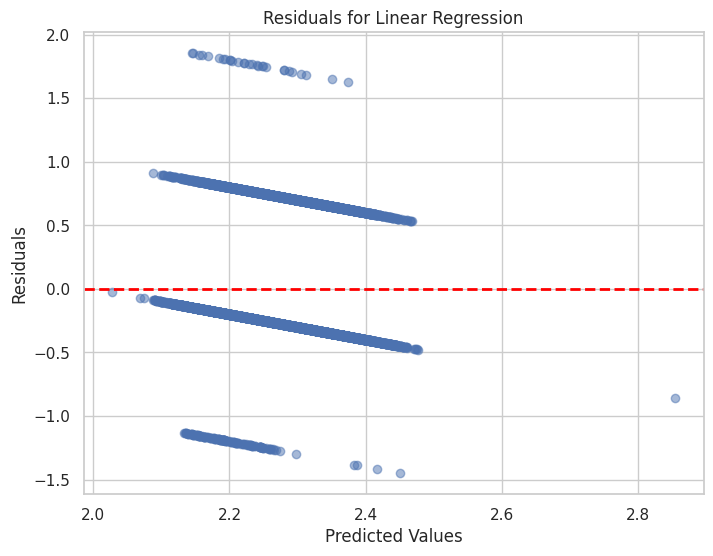

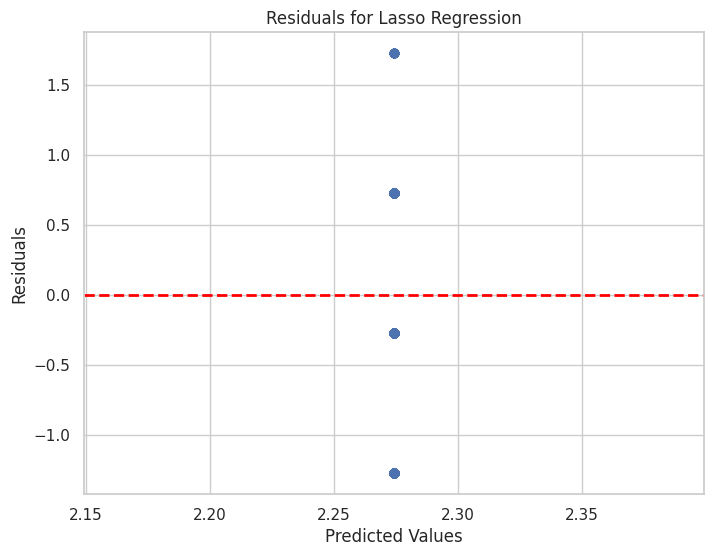

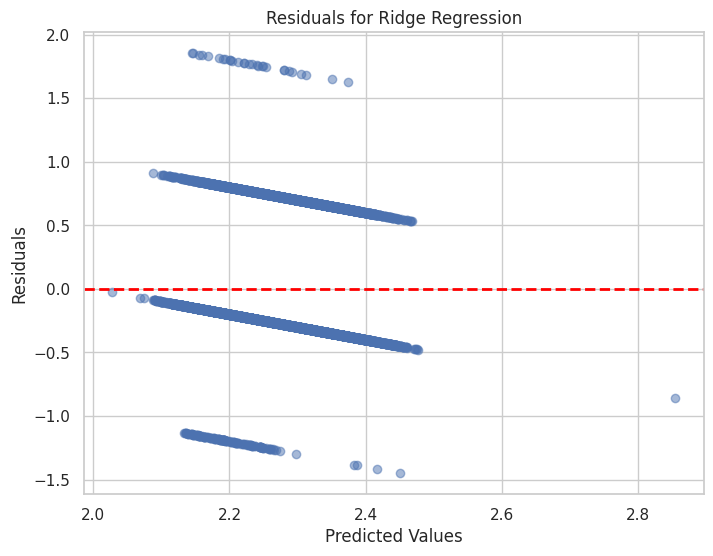

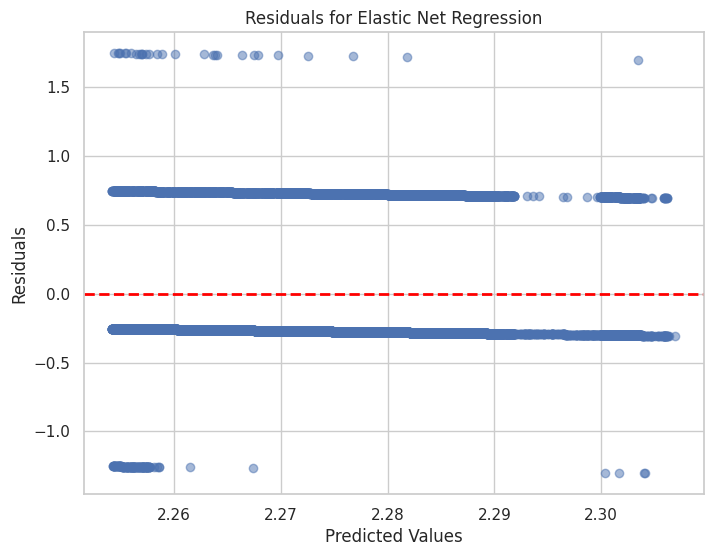

In [355]:
# Plot for Residual Analysis
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.title(f'Residuals for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

# Linear Regression Residuals
plot_residuals(y_test, y_test_pred_lr, 'Linear Regression')

# Lasso Regression Residuals
plot_residuals(y_test, y_test_pred_lasso, 'Lasso Regression')

# Ridge Regression Residuals
plot_residuals(y_test, y_test_pred_ridge, 'Ridge Regression')

# Elastic Net Regression Residuals
plot_residuals(y_test, y_test_pred_en, 'Elastic Net Regression')

# ARIMA

In [356]:
# ARIMA Modeling
# Prepare time series data for ARIMA
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()
ts = data['Severity'].resample('M').count()

# ARIMA model
def evaluate_arima(ts):
    best_mse = float('inf')
    best_order = None

    for p in range(3):
        for d in range(3):
            for q in range(3):
                try:
                    model = ARIMA(ts, order=(p, d, q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=12)

                    # Train-test split
                    train = ts[:-12]
                    test = ts[-12:]

                    mse = mean_squared_error(test, forecast)
                    print(f"ARIMA Order ({p},{d},{q}) - Mean Squared Error: {mse}")

                    if mse < best_mse:
                        best_mse = mse
                        best_order = (p, d, q)

                except Exception as e:
                    continue

    print(f"Best ARIMA Order: {best_order} - Best Mean Squared Error: {best_mse}")
    return best_order

# Evaluate ARIMA and select best order
best_order = evaluate_arima(ts)

# Fit final ARIMA model with best order
model = ARIMA(ts, order=best_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)

ARIMA Order (0,0,0) - Mean Squared Error: 448205.3933008138
ARIMA Order (0,0,1) - Mean Squared Error: 467667.29668114055
ARIMA Order (0,0,2) - Mean Squared Error: 460358.1196809682
ARIMA Order (0,1,0) - Mean Squared Error: 216114.16666666666
ARIMA Order (0,1,1) - Mean Squared Error: 165255.5915778754
ARIMA Order (0,1,2) - Mean Squared Error: 191534.49295222314
ARIMA Order (0,2,0) - Mean Squared Error: 8575489.000000006
ARIMA Order (0,2,1) - Mean Squared Error: 580715.0571098612
ARIMA Order (0,2,2) - Mean Squared Error: 462755.10414684186
ARIMA Order (1,0,0) - Mean Squared Error: 143416.7312299788
ARIMA Order (1,0,1) - Mean Squared Error: 129416.61511727671
ARIMA Order (1,0,2) - Mean Squared Error: 135592.830324708
ARIMA Order (1,1,0) - Mean Squared Error: 166525.29490074838
ARIMA Order (1,1,1) - Mean Squared Error: 172055.1352015847
ARIMA Order (1,1,2) - Mean Squared Error: 188956.99328251788
ARIMA Order (1,2,0) - Mean Squared Error: 3895128.3557910346
ARIMA Order (1,2,1) - Mean Square

Best ARIMA Order: (2, 0, 0) - Best Mean Squared Error: 129133.67332015537

# SARIMA

In [357]:
# SARIMA Modeling
# Define SARIMA model parameters
def evaluate_sarima(ts):
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None

    for p in range(3):
        for d in range(2):
            for q in range(3):
                for sp in range(2):
                    for sd in range(2):
                        for sq in range(2):
                            try:
                                seasonal_order = (sp, sd, sq, 12)  # Seasonality of 12 months
                                model = SARIMAX(ts, order=(p, d, q), seasonal_order=seasonal_order)
                                model_fit = model.fit(disp=False)

                                if model_fit.aic < best_aic:
                                    best_aic = model_fit.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = seasonal_order

                            except Exception as e:
                                continue

    print(f"Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}, AIC: {best_aic}")
    return best_order, best_seasonal_order

# Evaluate SARIMA and select best order
best_order, best_seasonal_order = evaluate_sarima(ts)

# Fit final SARIMA model with best order
sarima_model = SARIMAX(ts, order=best_order, seasonal_order=best_seasonal_order)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=12)

# Evaluate SARIMA model on test data
sarima_mse = mean_squared_error(ts[-12:], sarima_forecast[:12])
print(f"SARIMA Mean Squared Error on test data: {sarima_mse}")

Best SARIMA Order: (0, 1, 1), Seasonal Order: (0, 1, 1, 12), AIC: 579.405658674292
SARIMA Mean Squared Error on test data: 490829.22158613027


# COMBINED PLOT OF ARIMA AND SARIMA

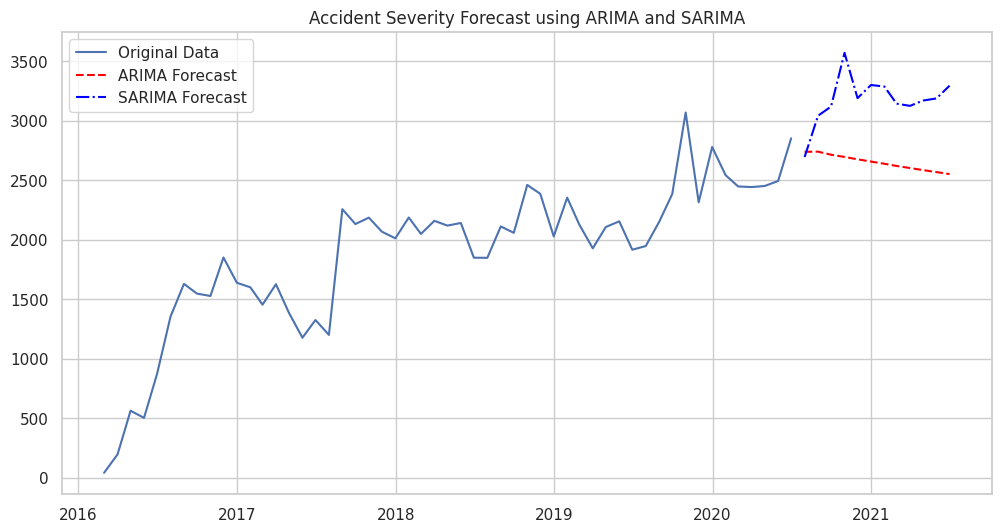

In [358]:
# Combined visualization for ARIMA and SARIMA forecasts
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Original Data')
plt.plot(forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='blue', linestyle='-.')
plt.title('Accident Severity Forecast using ARIMA and SARIMA')
plt.legend()
plt.show()

The ARIMA (AutoRegressive Integrated Moving Average) model is widely used for time-series forecasting. It focuses on modeling the trends and patterns within a dataset by accounting for non-stationarity. ARIMA operates by combining three components: an autoregressive (AR) term to model the relationship between a data point and its predecessors, an integrated (I) term to account for differences in the data, and a moving average (MA) term to account for residual errors. However, ARIMA does not explicitly handle seasonality. In this graph, the ARIMA model predicts a declining trend in accident severity after the observed data, suggesting it struggles to capture the inherent periodic fluctuations visible in the historical data.

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is an extension of ARIMA that incorporates a seasonal component into the model, allowing it to capture cyclical patterns in the data. SARIMA adds four additional parameters to account for seasonality: seasonal autoregressive, seasonal differencing, seasonal moving average, and the seasonal period. In this graph, SARIMA captures the periodic trends in the accident severity data effectively, reflecting the seasonal behavior seen in the historical data. This enables SARIMA to provide a more accurate and realistic forecast compared to ARIMA.